<a href="https://colab.research.google.com/github/IbrahimAlshubaily/deep_rl/blob/main/PG_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Colab Environment 

In [2]:
#Install Roms for gym: https://stackoverflow.com/questions/67656740/exception-rom-is-missing-for-ms-pacman-see-https-github-com-openai-atari-py
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars
clear_output()

In [1]:
import jax
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()

import jax.numpy as jnp
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Relu, LogSoftmax, Softmax)
from jax import grad, jit, vmap, value_and_grad
from IPython.display import clear_output
!pip install optax
clear_output()
import optax
print(jax.device_count(), jax.devices())
key = jax.random.PRNGKey(seed=0)

1 [GpuDevice(id=0, process_index=0)]


In [2]:
import gym
import time
import random
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

#Agent

In [3]:
#From Andrej Pong from Pixels blog: http://karpathy.github.io/2016/05/31/rl/
def prepro(I):
    I = I[35:195:2,::2, 0] # crop and downsample by factor of 2
    I[(I == 144) | (I == 109)] = 0 # erase background
    I[I != 0] = 1 # everything else (paddles, ball) set to 1
    return I.astype(np.float32)

def discounted_rewards(rewards, discount_rate = 0.98):
    for i in reversed(range(len(rewards)-1)):
        if rewards[i] == 0:  
            rewards[i] += discount_rate * rewards[i+1]
    return np.asarray(rewards).astype(np.float32)

def select_action(state):
  action_probs = np.exp(conv_net(params, np.expand_dims(state, axis=0)))
  action = np.random.choice([0,1], 1, p=action_probs[0])[0]
  return action

################################################################################

def loss_fn(params, batch, gamma=0.99):
    state, action, reward = batch
    masks =  jnp.array(action[:, None] == jnp.arange(2), dtype=jnp.float32)
    log_probs = jnp.sum(jnp.multiply(conv_net(params, state), masks), axis=1)
    return -jnp.mean((log_probs * reward))

@jit
def update(i, params, learner_state, batch):
  value, grads = jax.value_and_grad(loss_fn)(params, batch)
  grads = [(jnp.clip(g[0], a_min=-0.5, a_max=0.5), jnp.clip(g[1], a_min=-1, a_max=1))  if len(g) else () for g in grads] #clip w, b of paramtarized layers
  updates, learner_state = optimizer.update(grads, learner_state)
  params = optax.apply_updates(params, updates)
  return value, params, learner_state

## Model & Hyperparamters

In [9]:
init_fun, conv_net = stax.serial(Conv(16, (8,8), (8,8)), Relu,
                                 Conv(32, (4,4), (2,2)), Relu,
                                 Flatten, Dense(128), Relu,
                                 Dense(2), LogSoftmax)

batch_size = 512
_, params = init_fun(key, (batch_size, 80, 80, 1))

optimizer = optax.adam(0.00025)
learner_state = optimizer.init(params)

################################################################################
step=0
losses = []
skip_frames = 2
running_rewards =[-21]
env = gym.make("PongDeterministic-v4")

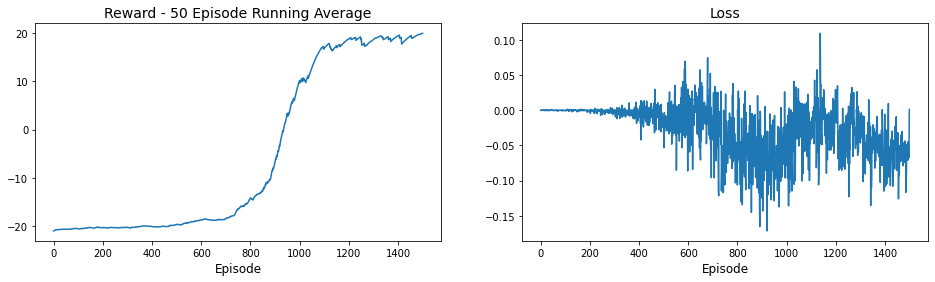

Episode: 1499   Episode_score: 21.0   Actions sample: []


In [10]:
for episode in range(1500):
    done = False
    reward_stat = 0
    screen = prepro(env.reset())
    state = np.dstack([screen, screen])
    next_state = state
    eps_state, eps_action, eps_reward = [],[],[]
    eps_loss = 0
    step = 0
    while not done:
        step+=1
        state = np.expand_dims(state[:,:,1] - state[:,:,0], axis=2)
        action = select_action(state)
        reward = 0
        for _ in range(skip_frames):
            if done: break
            screen, r, done, _ = env.step(action+2)
            reward+=r
        
        next_state[:,:,0] = next_state[:,:,1]
        next_state[:,:,1] = prepro(screen)
        eps_state.append(state), eps_action.append(action), eps_reward.append(reward)
        state = next_state
        reward_stat+=reward 

        if step > 500 and reward != 0 : 
            step = 0
            eps_reward = discounted_rewards(eps_reward) 
            eps_reward -= eps_reward.mean()
            eps_reward /= eps_reward.std()
            loss_value, params, learner_state = update(step, params, learner_state, [jnp.asarray(eps_state), jnp.asarray(eps_action), jnp.asarray(eps_reward)])
            eps_loss +=  loss_value 
            eps_state, eps_action, eps_reward = [],[],[]
    ############################################################################

    running_rewards.append(0.98 * running_rewards[-1] + 0.02 * reward_stat)
    losses.append(eps_loss)
    clear_output(wait=True) 
    figure, axis = plt.subplots(1, 2, sharex=True, figsize=(16,4))
    axis[0].plot(np.array(running_rewards))
    axis[0].set_title("Reward - 50 Episode Running Average", fontsize=14)
    axis[0].set_xlabel('Episode', fontsize=12)
    axis[1].plot(np.array(losses))
    axis[1].set_title("Loss", fontsize=14)
    axis[1].set_xlabel('Episode', fontsize=12)
    plt.show() 
    print("Episode: {}   Episode_score: {}   Actions sample: {}".format(episode, reward_stat, np.bincount(eps_action)))


In [17]:
screen = prepro(env.reset())
state = np.dstack([screen, screen])
r1,r2  = 0,0
frames = []
scores = []
done = False
while not done:
    action = select_action(np.expand_dims(state[:,:,1]-state[:,:,0], axis=2))
    reward = 0
    for _ in range(skip_frames):
        if done: break
        screen, r, done, _ = env.step(action+2)
        reward+=r
    state[:,:,0] = state[:,:,1]
    state[:,:,1] = prepro(screen)
    frames.append(state[:,:,1]-state[:,:,0])
    if reward > 0: r1+=1
    elif reward < 0: r2+=1
    scores.append([r1,r2])

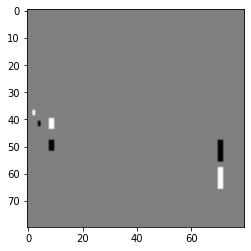

0 ------------------------------ 21


In [18]:
import time
for frame, score in zip(frames,scores):
    display.clear_output(wait=True)
    plt.imshow(frame, cmap='gray')
    plt.show()
    print(score[1],'-'*30,score[0])
    time.sleep(0.05)